In [1]:
import pandas as pd

# Data Loading

In [2]:
from api.data_handler import DataHandler

# Creation of a DataHandler Object
data_handler = DataHandler(['target', 'col1', 'col2', 'col3', 'col4', 'col5', 'col6', 'id'])

# Number of different Datasets
datasets_number = 3

# Lists of DataFrames
df_train : list[pd.DataFrame] = []
df_test  : list[pd.DataFrame] = []

# Load the Training/Test sets into pandas DataFrames
for i in range(datasets_number):
    df_train.append(data_handler.load_data(f'data/monks/monks-{i+1}.train'))
    df_test.append(data_handler.load_data(f'data/monks/monks-{i+1}.test'))

    # Print the head of the loaded data
    print(df_train[i].head())
    print(df_test[i].head())

     target  col1  col2  col3  col4  col5  col6       id
NaN       1     1     1     1     1     3     1   data_5
NaN       1     1     1     1     1     3     2   data_6
NaN       1     1     1     1     3     2     1  data_19
NaN       1     1     1     1     3     3     2  data_22
NaN       1     1     1     2     1     2     1  data_27
     target  col1  col2  col3  col4  col5  col6      id
NaN       1     1     1     1     1     1     1  data_1
NaN       1     1     1     1     1     1     2  data_2
NaN       1     1     1     1     1     2     1  data_3
NaN       1     1     1     1     1     2     2  data_4
NaN       1     1     1     1     1     3     1  data_5
     target  col1  col2  col3  col4  col5  col6       id
NaN       0     1     1     1     1     2     2   data_4
NaN       0     1     1     1     1     4     1   data_7
NaN       0     1     1     1     2     1     1   data_9
NaN       0     1     1     1     2     1     2  data_10
NaN       0     1     1     1     2  

# Data Split

In [3]:
# Lists of data
x_train : list[pd.DataFrame] = []
y_train : list[pd.DataFrame] = []
x_test  : list[pd.DataFrame] = []
y_test  : list[pd.DataFrame] = []

# Split data into TR set and TS set
for i in range(datasets_number):

    # Saving the splitted TR set data into the lists
    df_train[i] = df_train[i].drop(columns=['id'], axis=1).copy(deep=True)
    x, y = data_handler.split_data(data=df_train[i], cols_name_split=['target'])
    x_train.append(x)
    y_train.append(y)

    # Saving the splitted TS set data into the lists
    df_test[i] = df_test[i].drop(columns=['id'], axis=1).copy(deep=True)
    x, y = data_handler.split_data(data=df_test[i], cols_name_split=['target'])
    x_test.append(x)
    y_test.append(y)


# 1-Hot Encoding

In [4]:
# Applies the 1-Hot Encoding to the "x" data
for i in range(datasets_number):
    x_train[i] = data_handler.one_hot_encoding(x_train[i])
    x_test[i]  = data_handler.one_hot_encoding(x_test[i])

    # Print of the data modified
    print(f"Monk {i+1} [TR]: " + str(x_train[i].shape))
    print(f"Monk {i+1} [TS]: " + str(x_test[i].shape))

Monk 1 [TR]: (124, 17)
Monk 1 [TS]: (432, 17)
Monk 2 [TR]: (169, 17)
Monk 2 [TS]: (432, 17)
Monk 3 [TR]: (122, 17)
Monk 3 [TS]: (432, 17)


# Grid Search parameters

In [5]:
# Parameters' space for Grid Search (1 for each Dataset)
param_space = {
    0: {
        'input_size': [17],
        'hidden_size': [2, 3],
        'output_size': [1],
        'hidden_layers': [0],
        'input_activation': ['Sigmoid'],
        'hidden_activation': ['Tanh', 'Sigmoid'],
        'output_activation': ['Sigmoid'],
        'tolerance': [0.02],
        'learning_rate': [0.8, 0.4], #[float(i/10) for i in range(1,10)] + [float(i/100) for i in range(1,10)] + [0.001, 0.005],
        'batch_size': [2, 3], #[4, 7, 8, 9, 15, 16, 17, 31, 32, 33, 62, 63, 64, 65],
        'momentum': [0.4, 0.3], #[float(i/10) for i in range(3,10)],
        'weight_init': ["glorot_normal", "he_normal"], #["glorot_uniform", "glorot_normal", "he_uniform", "he_normal"],
        'epochs': [400, 350], #[int(350+epochs) for epochs in range(0,51,10)],
        'weight_decay': [0],
        'optimizer': ['SGD'],
        'metrics': ['accuracy'],
        'decimal_cypher_degree': [0]
    },
    1: { ### Perfect - NON MODIFICARE ###
        'input_size': [17],
        'hidden_size': [3, 4],
        'output_size': [1],
        'hidden_layers': [1],
        'input_activation': [''],
        'hidden_activation': ['Tanh'],
        'output_activation': ['Sigmoid'],
        'tolerance': [0.01],
        'learning_rate': [0.7, 0.1], #[float(i/10) for i in range(1,10)] + [float(i/100) for i in range(1,10)] + [0.001, 0.005],
        'batch_size': [2, 3, 5], #[4, 7, 8, 9, 15, 16, 17, 31, 32, 33, 62, 63, 64, 65],
        'momentum': [0.3, 0.8], #[float(i/10) for i in range(3,10)],
        'weight_init': ["glorot_normal", "he_normal"], #["glorot_uniform", "glorot_normal", "he_uniform", "he_normal"],
        'epochs': [400, 350], #[int(350+epochs) for epochs in range(0,51,10)],
        'weight_decay': [0],
        'optimizer': ['SGD'],
        'metrics': ['accuracy'],
        'decimal_cypher_degree': [0]
    },
    2: { # 'input_size': 17, 'hidden_size': 4, 'hidden_layers': 1, 'input_activation': 'Tanh', 'tolerance': 0.02, 'learning_rate': 0.01, 'batch_size': 2, 'momentum': 0.4, 'weight_init': 'glorot_normal', 'epochs': 350, 'weight_decay': 0.001, 'hidden_activation': 'ReLU', 'optimizer': 'SGD', 'metrics': 'accuracy'}
        'input_size': [17],
        'hidden_size': [3, 4],
        'output_size': [1],
        'hidden_layers': [1],
        'input_activation': ['Tanh'],
        'hidden_activation': ['Tanh'],
        'output_activation': ['Sigmoid'],
        'tolerance': [0.025],
        'learning_rate': [0.05, 0.07, 0.1], #[float(i/10) for i in range(1,10)] + [float(i/100) for i in range(1,10)] + [0.001, 0.005],
        'batch_size': [2, 3], #[4, 7, 8, 9, 15, 16, 17, 31, 32, 33, 62, 63, 64, 65],
        'momentum': [0], #[float(i/10) for i in range(3,10)],
        'weight_init': ["glorot_normal"], #["glorot_uniform", "glorot_normal", "he_uniform", "he_normal"],
        'epochs': [400, 350], #[int(350+epochs) for epochs in range(0,51,10)],
        'weight_decay': [0.01, 0.005, 0.001], #[float(i/100) for i in range(1,11)] + [0.001, 0.0001],
        'optimizer': ['SGD'],
        'metrics': ['accuracy'],
        'decimal_cypher_degree': [0]
    }
}

# Model Selection

## Best Hyperparameters Research

In [6]:
from sklearn.model_selection import StratifiedKFold
from api.pytorch.binary_nn import BinaryNN

# Creation of a BinaryNN objct for each dataset
nn: list[BinaryNN] = []

# Different values per dataset
trials_list = [1, 1, 20]   # 30, 30, 50
k_values = [5, 5, 5]

#datasets_number = 1

# Search of the best Hyperparameters to each Training set
for dataset_i in range(datasets_number):
    X = x_train[dataset_i].values.astype(dtype=float)
    y = y_train[dataset_i].values.astype(dtype=float)
    k = k_values[dataset_i]

    # K-fold Cross-validation
    kfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Sets all the combinations of the entire set of parameters
    #data_handler.set_params_combinations(params=param_space[dataset_i])

    # Gets the list with the combinations of all the parameters
    #params_combinations = data_handler.get_params_combinations()

    # For each iteration we choose the hyperparameters (randomly) and we use them with K-fold CV
    #for trial, params in enumerate(params_combinations):
    for trial in range(trials_list[dataset_i]):

        # Choose random hyperparameters
        params = data_handler.random_dictionary(params=param_space[dataset_i])

        # Creation of the Neural Network object
        nn_i = BinaryNN(params=params, current_trial=trial+1, trials=trials_list[dataset_i], monk_i=dataset_i+1)
        #nn_i = BinaryNN(params=params, current_trial=trial+1, trials=len(params_combinations), monk_i=dataset_i+1)
                        
        # For each K-fold returns the indexes of the data splitted in: <X_train,y_train> and <X_val,y_val>
        for train_index, val_index in kfold.split(X, y):
            x_kfold_train, x_kfold_val = X[train_index], X[val_index]
            y_kfold_train, y_kfold_val = y[train_index], y[val_index]

            nn_i.fit(
                x_train=x_kfold_train,
                y_train=y_kfold_train,
                x_val=x_kfold_val,
                y_val=y_kfold_val
            )

        # Case of first append
        if len(nn) == dataset_i:
            nn.append(nn_i)
        
        # Print the results of this trial
        print("\n------------------ Current Hyperparameters ------------------")
        nn_i.print_training_info()
        print("-------------------- Best Hyperparameters -------------------")
        nn[dataset_i].print_training_info()
        print("\n\n")

        # Update best hyperparameters if: no overfitting AND (higher mean VL accuracy OR (equal mean AND
        if nn_i.mean_tr_accuracy-0.1 <= nn_i.mean_vl_accuracy \
            and (
                nn[dataset_i].mean_vl_accuracy < nn_i.mean_vl_accuracy \
                or (
                    nn[dataset_i].mean_vl_accuracy == nn_i.mean_vl_accuracy \
                    and nn[dataset_i].mean_tr_accuracy < nn_i.mean_tr_accuracy
                )
            ):
            nn[dataset_i] = nn_i
        
        # Case of higher mean VL accuracy AND NO Overfitting
        if nn_i.mean_vl_accuracy > nn[dataset_i].mean_vl_accuracy \
            and (
                abs(nn_i.mean_tr_accuracy - nn_i.mean_vl_accuracy) < abs(nn[dataset_i].mean_tr_accuracy - nn[dataset_i].mean_vl_accuracy) \
                or abs(nn_i.mean_tr_accuracy - nn_i.mean_vl_accuracy) < 0.02
            ):
            nn[dataset_i] = nn_i
        
        # Exit case
        if nn_i.mean_tr_accuracy == 1 and nn_i.mean_vl_accuracy == 1 \
            and nn_i.mean_vl_loss < 0.1 and nn_i.mean_tr_loss < 0.1 \
            and abs(nn_i.mean_vl_loss - nn_i.mean_tr_loss) < 0.01:
            nn[dataset_i] = nn_i
            break

    # Print output
    print(f"### Best Hyperparameters of Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()
    print("\n\n")


/Users/gianlucapanzani/anaconda3/envs/ML/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: Using a target size (torch.Size([3, 1])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)
/Users/gianlucapanzani/anaconda3/envs/ML/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)



------------------ Current Hyperparameters ------------------
 Monk:                     1
 Trial:                    1/1
 Hyperparameters:          {'input_size': 17, 'hidden_size': 2, 'output_size': 1, 'hidden_layers': 0, 'input_activation': 'Sigmoid', 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'tolerance': 0.02, 'learning_rate': 0.4, 'batch_size': 3, 'momentum': 0.3, 'weight_init': 'glorot_normal', 'epochs': 350, 'weight_decay': 0, 'optimizer': 'SGD', 'metrics': 'accuracy', 'decimal_cypher_degree': 0}
 Mean Training Loss:       0.23532675361122923
 Mean Validation Loss:     0.23270225487770393
 Mean Training Accuracy:   0.8742226047044215
 Mean Validation Accuracy: 0.8581601731601282
-------------------- Best Hyperparameters -------------------
 Monk:                     1
 Trial:                    1/1
 Hyperparameters:          {'input_size': 17, 'hidden_size': 2, 'output_size': 1, 'hidden_layers': 0, 'input_activation': 'Sigmoid', 'hidden_activation': 'Tanh', '

/Users/gianlucapanzani/anaconda3/envs/ML/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)
/Users/gianlucapanzani/anaconda3/envs/ML/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)
/Users/gianlucapanzani/anaconda3/envs/ML/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return fu


------------------ Current Hyperparameters ------------------
 Monk:                     2
 Trial:                    1/1
 Hyperparameters:          {'input_size': 17, 'hidden_size': 3, 'output_size': 1, 'hidden_layers': 1, 'input_activation': '', 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'tolerance': 0.01, 'learning_rate': 0.1, 'batch_size': 5, 'momentum': 0.3, 'weight_init': 'glorot_normal', 'epochs': 350, 'weight_decay': 0, 'optimizer': 'SGD', 'metrics': 'accuracy', 'decimal_cypher_degree': 0}
 Mean Training Loss:       0.22840050751875543
 Mean Validation Loss:     0.22878131426110573
 Mean Training Accuracy:   0.7831470588234457
 Mean Validation Accuracy: 0.7869632653061451
-------------------- Best Hyperparameters -------------------
 Monk:                     2
 Trial:                    1/1
 Hyperparameters:          {'input_size': 17, 'hidden_size': 3, 'output_size': 1, 'hidden_layers': 1, 'input_activation': '', 'hidden_activation': 'Tanh', 'output_activat

/Users/gianlucapanzani/anaconda3/envs/ML/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: Using a target size (torch.Size([3, 1])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)
/Users/gianlucapanzani/anaconda3/envs/ML/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)
/Users/gianlucapanzani/anaconda3/envs/ML/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return fu


------------------ Current Hyperparameters ------------------
 Monk:                     3
 Trial:                    1/20
 Hyperparameters:          {'input_size': 17, 'hidden_size': 3, 'output_size': 1, 'hidden_layers': 1, 'input_activation': 'Tanh', 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'tolerance': 0.025, 'learning_rate': 0.05, 'batch_size': 3, 'momentum': 0, 'weight_init': 'glorot_normal', 'epochs': 350, 'weight_decay': 0.001, 'optimizer': 'SGD', 'metrics': 'accuracy', 'decimal_cypher_degree': 0}
 Mean Training Loss:       0.2293873525219304
 Mean Validation Loss:     0.23034824965255588
 Mean Training Accuracy:   0.9228975468974658
 Mean Validation Accuracy: 0.9121541950113002
-------------------- Best Hyperparameters -------------------
 Monk:                     3
 Trial:                    1/20
 Hyperparameters:          {'input_size': 17, 'hidden_size': 3, 'output_size': 1, 'hidden_layers': 1, 'input_activation': 'Tanh', 'hidden_activation': 'Tanh', 'o

/Users/gianlucapanzani/anaconda3/envs/ML/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: Using a target size (torch.Size([3, 1])) that is different to the input size (torch.Size([3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)
/Users/gianlucapanzani/anaconda3/envs/ML/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)


KeyboardInterrupt: 

## Print of best Hyperparameters and Plots

In [ ]:
# Iteration on all the Datasets
for dataset_i in range(datasets_number):

    # Print best hyperparameters
    print(f"\n### Best Hyperparameters for Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()



### Best Hyperparameters for Monk 1 ###
 Monk:                     1
 Trial:                    1/1
 Hyperparameters:          {'input_size': 17, 'hidden_size': 3, 'output_size': 1, 'hidden_layers': 0, 'input_activation': 'Sigmoid', 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'tolerance': 0.02, 'learning_rate': 0.8, 'batch_size': 2, 'momentum': 0.3, 'weight_init': 'he_normal', 'epochs': 350, 'weight_decay': 0, 'optimizer': 'SGD', 'metrics': 'accuracy'}
 Mean Training Loss:       0.20331759057553164
 Mean Validation Loss:     0.20426598274489896
 Mean Training Accuracy:   0.9320399999999986
 Mean Validation Accuracy: 0.9171205357142861

### Best Hyperparameters for Monk 2 ###
 Monk:                     2
 Trial:                    1/1
 Hyperparameters:          {'input_size': 17, 'hidden_size': 4, 'output_size': 1, 'hidden_layers': 1, 'input_activation': '', 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'tolerance': 0.01, 'learning_rate': 0.7, 'batch_siz

## Retraining Phase


### Retraining of Monk 1 ###
 Monk:                     1
 Trial:                    1/1
 Hyperparameters:          {'input_size': 17, 'hidden_size': 3, 'output_size': 1, 'hidden_layers': 0, 'input_activation': 'Sigmoid', 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'tolerance': 0.02, 'learning_rate': 0.8, 'batch_size': 2, 'momentum': 0.3, 'weight_init': 'he_normal', 'epochs': 350, 'weight_decay': 0, 'optimizer': 'SGD', 'metrics': 'accuracy'}
 Mean Training Loss:       0.20331524619837793
 Mean Validation Loss:     0.20426598274489896
 Mean Training Accuracy:   0.9320310180215149
 Mean Validation Accuracy: 0.9171205357142861

### Retraining of Monk 2 ###
 Monk:                     2
 Trial:                    1/1
 Hyperparameters:          {'input_size': 17, 'hidden_size': 4, 'output_size': 1, 'hidden_layers': 1, 'input_activation': '', 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'tolerance': 0.01, 'learning_rate': 0.7, 'batch_size': 5, 'momentum': 0.3

/Users/gianlucapanzani/anaconda3/envs/ML/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)
/Users/gianlucapanzani/anaconda3/envs/ML/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)


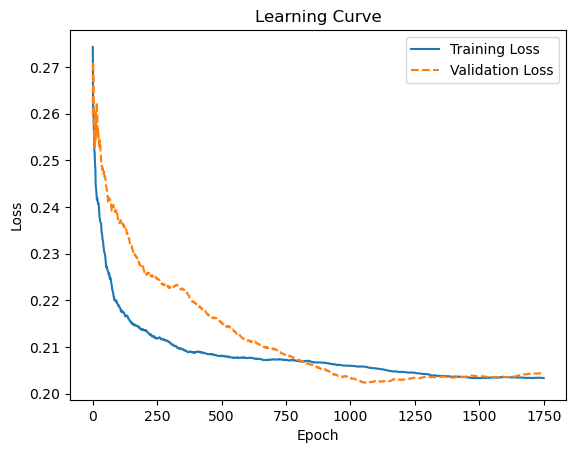

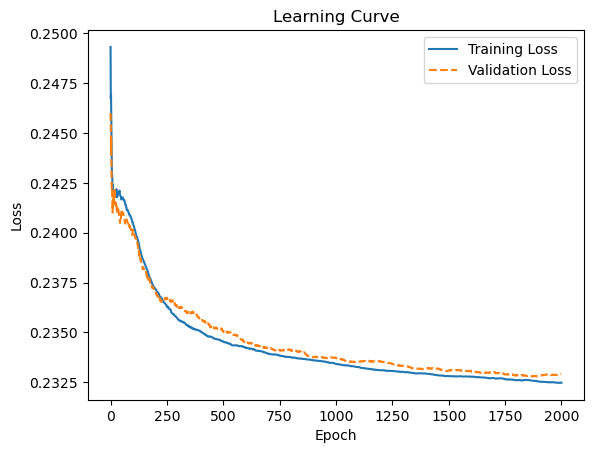

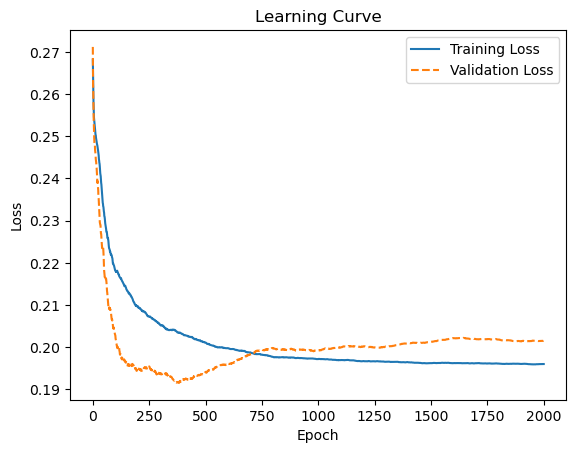

In [ ]:
# Iterations on each Dataset
for dataset_i in range(datasets_number):

    # Training the model
    nn[dataset_i].fit(
        x_train=x_train[dataset_i].values,
        y_train=y_train[dataset_i].values
    )

    # Print values
    print(f"\n### Retraining of Monk {dataset_i+1} ###")
    nn[dataset_i].print_training_info()
    nn[dataset_i].print_plot()

## Evaluation on different Weights Initializations

In [ ]:
import numpy as np

# Iterations on each Dataset
'''for dataset_i in range(datasets_number):

    # Initializations
    mean_accuracies_list = []

    # Iterations for compute the mean of the accuracy of each Best Model
    iterations = 5
    for i in range(iterations):
        x_train, x_val = data_handler.split_data(
            data=df_train[dataset_i], y_cols_name=['target'], split_perc=0.9, axis=0
        ).values.astype(dtype=float)
        y_train, y_val = data_handler.split_data(
            data=df_test[dataset_i], y_cols_name=['target'], split_perc=0.9, axis=0
        ).values.astype(dtype=float)


        # Creates the model with the Best Hyperparameters
        nn_i = BinaryNN(params=nn[dataset_i].params, monk_i=dataset_i+1, current_trial=i+1, trials=iterations,
                        n_hidden_layers=n_hidden_layers_list[dataset_i])
        
        # Training the model
        nn_i.fit(
            x_train=x_train,
            y_train=y_train,
            x_val=x_val,
            y_val=y_val
        )

        # Append the evaluation values
        mean_accuracies_list.append(nn_i.mean_vl_accuracy)

    mean_accuracy = np.mean(mean_accuracies_list)
    print(mean_accuracy)'''

"for dataset_i in range(datasets_number):\n\n    # Initializations\n    mean_accuracies_list = []\n\n    # Iterations for compute the mean of the accuracy of each Best Model\n    iterations = 5\n    for i in range(iterations):\n        x_train, x_val = data_handler.split_data(\n            data=df_train[dataset_i], y_cols_name=['target'], split_perc=0.9, axis=0\n        ).values.astype(dtype=float)\n        y_train, y_val = data_handler.split_data(\n            data=df_test[dataset_i], y_cols_name=['target'], split_perc=0.9, axis=0\n        ).values.astype(dtype=float)\n\n\n        # Creates the model with the Best Hyperparameters\n        nn_i = BinaryNN(params=nn[dataset_i].params, monk_i=dataset_i+1, current_trial=i+1, trials=iterations,\n                        n_hidden_layers=n_hidden_layers_list[dataset_i])\n        \n        # Training the model\n        nn_i.fit(\n            x_train=x_train,\n            y_train=y_train,\n            x_val=x_val,\n            y_val=y_val\n    

# Testing Phase

(432, 17)
(432, 1)
 Monk:                     1
 Trial:                    1
 Hyperparameters:          {'input_size': 17, 'hidden_size': 3, 'output_size': 1, 'hidden_layers': 0, 'input_activation': 'Sigmoid', 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'tolerance': 0.02, 'learning_rate': 0.8, 'batch_size': 2, 'momentum': 0.3, 'weight_init': 'he_normal', 'epochs': 350, 'weight_decay': 0, 'optimizer': 'SGD', 'metrics': 'accuracy'}
 Mean Training Loss:       0.20331524619837793
 Mean Validation Loss:     0.20426598274489896
 Test Loss:                0.4808233587077239
 Mean Training Accuracy:   0.9320310180215149
 Mean Validation Accuracy: 0.9171205357142861
 Test Accuracy:            0.5138888888888888
 f1 score:                 0.05405405405405406
 f2 score:                 0.034482758620689655
 Prediction score:         1.0
 Recall score:             0.027777777777777776

              Predicted_Class_0  Predicted_Class_1
Real_Class_0                216              

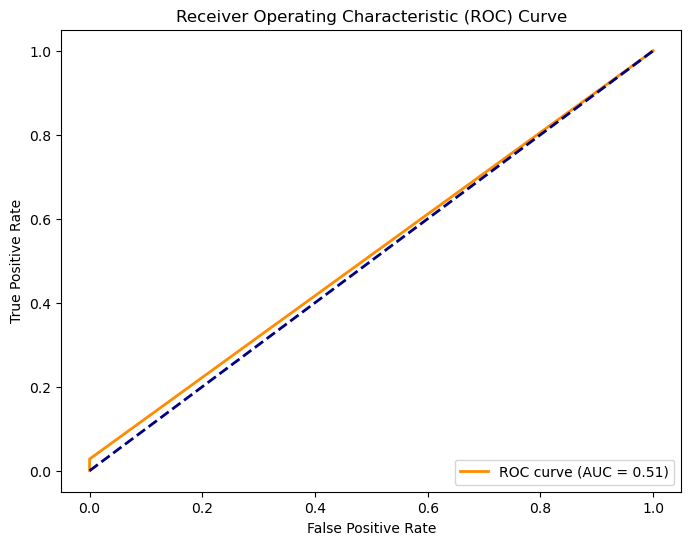

(432, 17)
(432, 1)
 Monk:                     2
 Trial:                    1
 Hyperparameters:          {'input_size': 17, 'hidden_size': 4, 'output_size': 1, 'hidden_layers': 1, 'input_activation': '', 'hidden_activation': 'Tanh', 'output_activation': 'Sigmoid', 'tolerance': 0.01, 'learning_rate': 0.7, 'batch_size': 5, 'momentum': 0.3, 'weight_init': 'glorot_normal', 'epochs': 400, 'weight_decay': 0, 'optimizer': 'SGD', 'metrics': 'accuracy'}
 Mean Training Loss:       0.2324734744014465
 Mean Validation Loss:     0.23289930724352606
 Test Loss:                0.4340551272462839
 Mean Training Accuracy:   0.7503270015063621
 Mean Validation Accuracy: 0.7455547619047644
 Test Accuracy:            0.5436781609195401
 f1 score:                 0.4573002754820937
 f2 score:                 0.5259822560202788
 Prediction score:         0.3755656108597285
 Recall score:             0.5845070422535211

              Predicted_Class_0  Predicted_Class_1
Real_Class_0                152        

/Users/gianlucapanzani/anaconda3/envs/ML/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: Using a target size (torch.Size([5, 1])) that is different to the input size (torch.Size([5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)
/Users/gianlucapanzani/anaconda3/envs/ML/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)


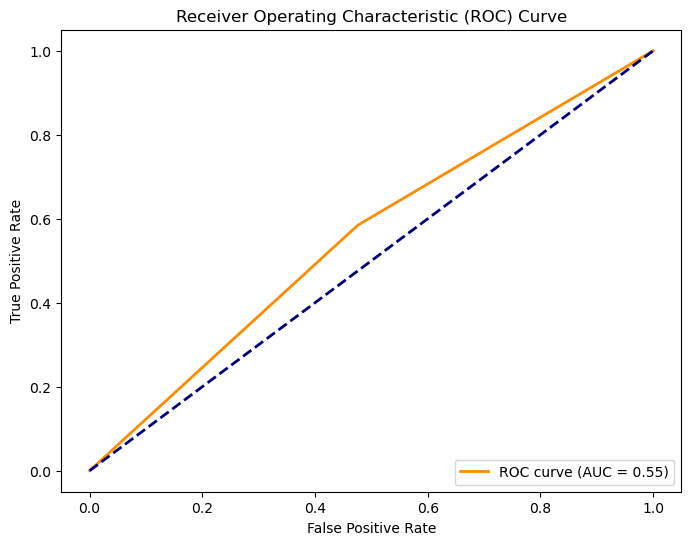

(432, 17)
(432, 1)
 Monk:                     3
 Trial:                    1
 Hyperparameters:          {'input_size': 17, 'hidden_size': 3, 'output_size': 1, 'hidden_layers': 1, 'input_activation': 'Tanh', 'hidden_activation': 'ReLU', 'output_activation': 'Sigmoid', 'tolerance': 0.025, 'learning_rate': 0.05, 'batch_size': 2, 'momentum': 0, 'weight_init': 'glorot_normal', 'epochs': 400, 'weight_decay': 0.001, 'optimizer': 'SGD', 'metrics': 'accuracy'}
 Mean Training Loss:       0.1960107412393936
 Mean Validation Loss:     0.2015536090845593
 Test Loss:                0.29038827356675445
 Mean Training Accuracy:   0.9691824476601302
 Mean Validation Accuracy: 0.9467540322580648
 Test Accuracy:            0.5810185185185184
 f1 score:                 0.4564564564564564
 f2 score:                 0.37364798426745327
 Prediction score:         0.7238095238095238
 Recall score:             0.3333333333333333

              Predicted_Class_0  Predicted_Class_1
Real_Class_0                17

/Users/gianlucapanzani/anaconda3/envs/ML/lib/python3.10/site-packages/torch/utils/_device.py:77: UserWarning: Using a target size (torch.Size([2, 1])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return func(*args, **kwargs)


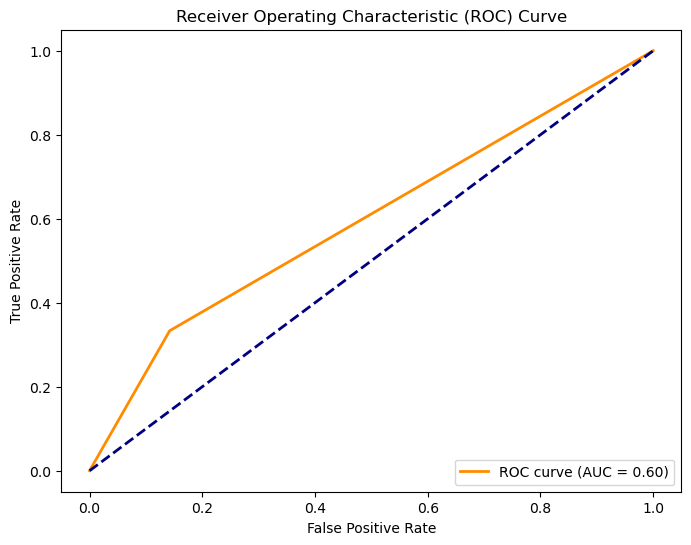

In [ ]:

# Evaluation of the Models for each Test set
for dataset_i in range(datasets_number):
    print(x_test[dataset_i].shape)
    print(y_test[dataset_i].shape)
    
    X = x_test[dataset_i].values
    y = y_test[dataset_i].values

    # Evaluate the Model on TS set
    nn[dataset_i].test(
        x_test=X,
        y_test=y
    )

    # Computes the score of the Model
    nn[dataset_i].score()

    # Prints the results obtained
    print(nn[dataset_i])
    nn[dataset_i].print_confusion_matrix(y_test=y)
    nn[dataset_i].print_roc_curve(y_test=y)


